In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold

In [12]:
data = pd.read_csv("20221027-adni-db-for-R.csv.gz", compression="gzip")
data.head()

<ipython-input-12-f1eb8e56b04e>:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("20221027-adni-db-for-R.csv.gz", compression="gzip")


,PTID,M,interp_grouping,amyloid_positive,CDRSB_decliner_05,CDRSB_decliner_1,MMSE_decliner_2,PLASMA_NFL,WU_STREM2,MSD_PGRN,...,wm_mask__fat,wm_mask__fw,wm_mask__icvf,wm_mask__isovf,wm_mask__md,wm_mask__mdt,wm_mask__nufo,wm_mask__od,wm_mask__rd,wm_mask__rdt
0,002_S_4213,72.0,NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.297076,0.041422,NaN,NaN,0.000817,0.000774,3.013491,NaN,0.000688,0.000644
1,002_S_4225,84.0,AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,002_S_4225,84.0,AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.330879,0.026214,NaN,NaN,0.000784,0.000758,2.885436,NaN,0.000641,0.000614
3,002_S_4229,72.0,MCI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,002_S_4229,72.0,MCI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.324193,0.019190,NaN,NaN,0.000767,0.000747,2.882402,NaN,0.000628,0.000608


In [13]:
print(data.columns)

Index(['PTID', 'M', 'interp_grouping', 'amyloid_positive', 'CDRSB_decliner_05',
       'CDRSB_decliner_1', 'MMSE_decliner_2', 'PLASMA_NFL', 'WU_STREM2',
       'MSD_PGRN',
       ...
       'wm_mask__fat', 'wm_mask__fw', 'wm_mask__icvf', 'wm_mask__isovf',
       'wm_mask__md', 'wm_mask__mdt', 'wm_mask__nufo', 'wm_mask__od',
       'wm_mask__rd', 'wm_mask__rdt'],
      dtype='object', length=744)


#Notes
Nous avons demandé à Chat GPT les features les plus pertinentes et j'ai obtenu cette réponse:

Voici la liste des colonnes disponibles dans votre dataset :

## 🏆 Synthèse et Recommandations

| Variable          | Pertinence pour la classification               | Meilleur usage                      |
|------------------|----------------------------------|-----------------------------|
| `amyloid_positive` | Distinction **NC** vs **MCI/AD** | Diagnostic précoce         |
| `PLASMA_NFL`      | Indique la sévérité du déclin  | Suivi de la progression    |
| `wm_mask_fw`      | Marqueur précoce              | Identification des sujets à risque |
| `wm_mask_rdt`     | Suivi des altérations structurelles | Progression de **MCI** vers **AD** |
| `wm_mask_afd_total` | Mesure de la connectivité neuronale | Détection des premiers signes |

✅ **Les biomarqueurs doivent être combinés pour obtenir une meilleure classification.**  

✅ **L'amyloïde est utile pour identifier les sujets à risque, mais les marqueurs** `NFL` **et imagerie cérébrale sont meilleurs pour suivre l'évolution vers** `AD`.  


# Regardons l'amyloid positive

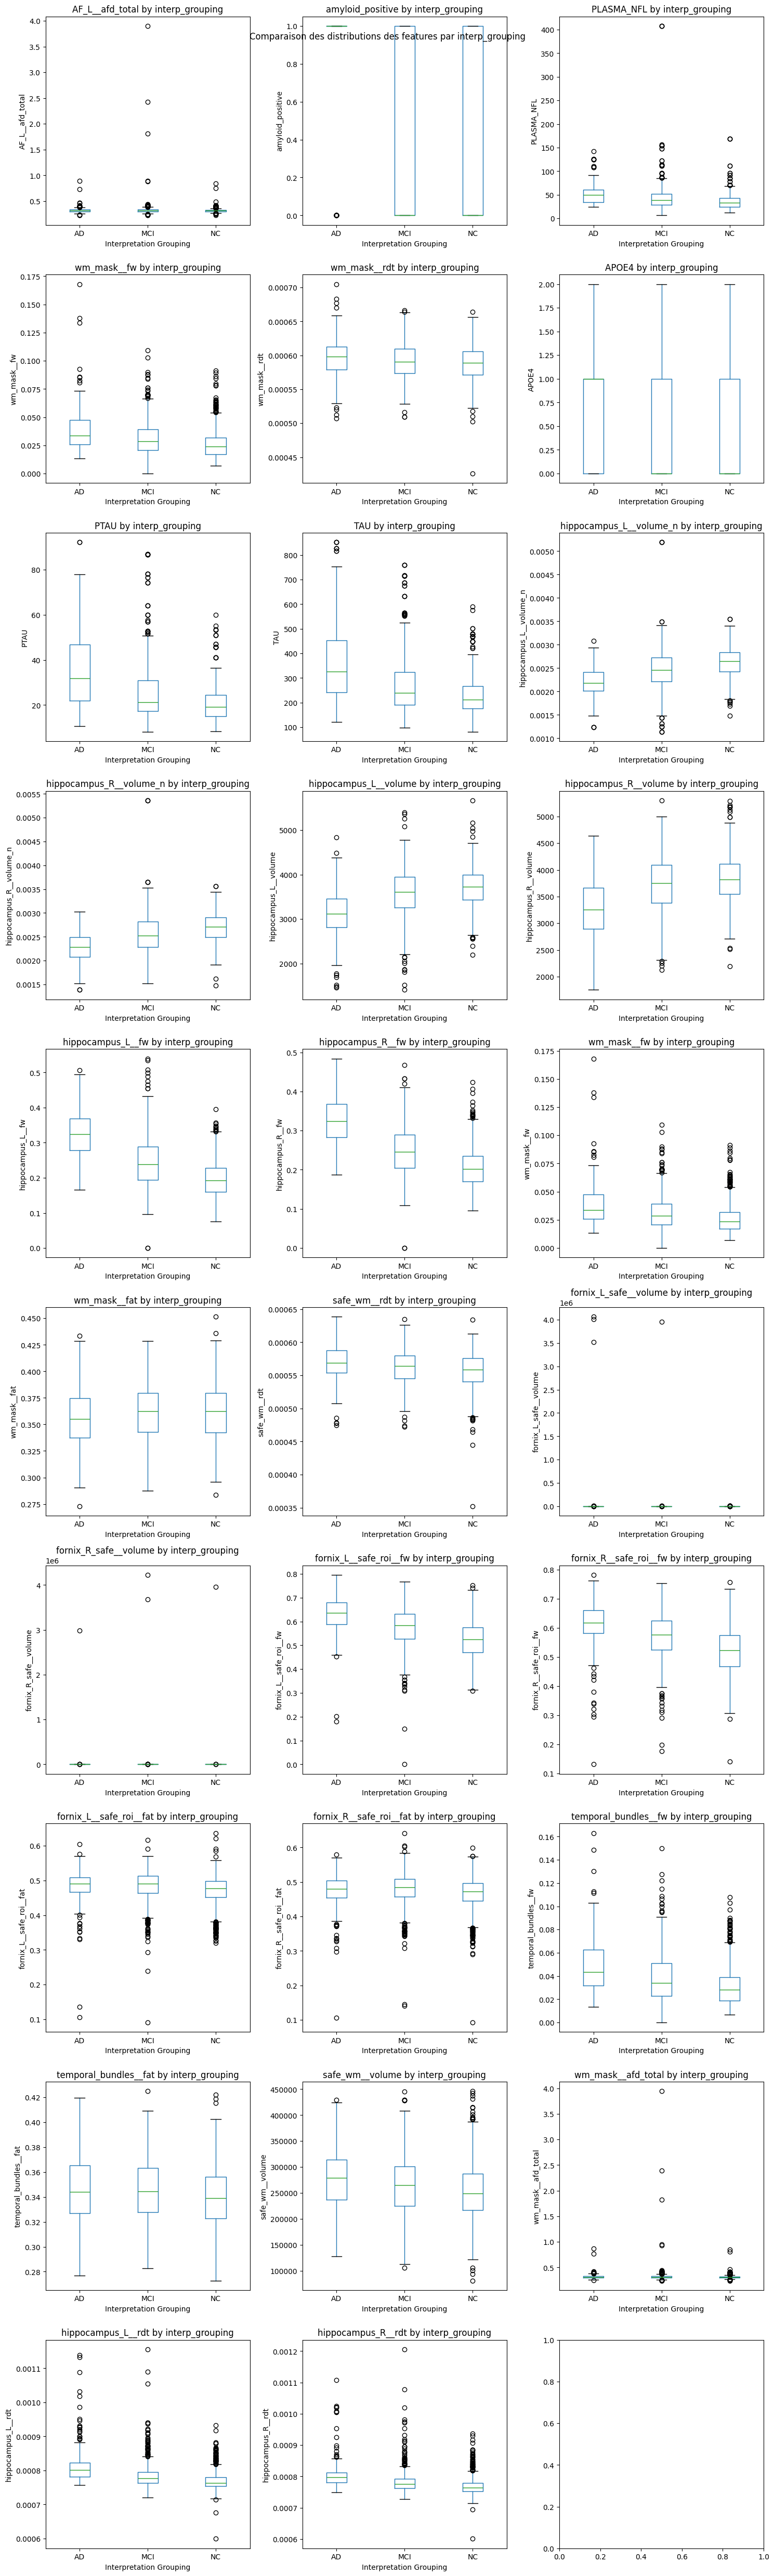

In [14]:

# Colonnes à analyser
colonnes = [
    'AF_L__afd_total', 'amyloid_positive', 'PLASMA_NFL', 'wm_mask__fw', 'wm_mask__rdt', 'APOE4', 'PTAU', 'TAU',
    'hippocampus_L__volume_n', 'hippocampus_R__volume_n', 'hippocampus_L__volume', 'hippocampus_R__volume',
    'hippocampus_L__fw', 'hippocampus_R__fw', 'wm_mask__fw', 'wm_mask__fat', 'safe_wm__rdt','fornix_L_safe__volume',
    'fornix_R_safe__volume','fornix_L__safe_roi__fw','fornix_R__safe_roi__fw','fornix_L__safe_roi__fat','fornix_R__safe_roi__fat',
    'temporal_bundles__fw','temporal_bundles__fat','safe_wm__volume','wm_mask__afd_total','hippocampus_L__rdt','hippocampus_R__rdt'
]


# Stockage des scores de distinction (variance intra-groupe)
variance_scores = {}

# Nombre de colonnes par ligne pour affichage des plots
cols_per_row = 3
num_rows = int(np.ceil(len(colonnes) / cols_per_row))

# Création de la figure pour afficher les plots côte à côte
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 5, num_rows * 5))
axes = axes.flatten()  # Pour indexer facilement les axes

# Parcours de chaque colonne
for idx, col in enumerate(colonnes):
    if col in data.columns:  # Vérification que la colonne existe
        # Filtrage des données pour exclure les valeurs NaN
        filtered_data = data.loc[data[col].notna(), [col, 'interp_grouping']]

        # Conversion en numérique pour éviter les erreurs de type
        filtered_data[col] = pd.to_numeric(filtered_data[col], errors='coerce')

        # Calcul de la variance par groupe
        group_variance = filtered_data.groupby('interp_grouping')[col].var()

        # Stockage du score de distinction (plus la variance est élevée, mieux c'est)
        variance_scores[col] = group_variance.mean()

        # Création du boxplot pour visualiser la répartition des valeurs
        filtered_data.boxplot(column=col, by="interp_grouping", ax=axes[idx], grid=False)
        axes[idx].set_title(f"{col} by interp_grouping")
        axes[idx].set_xlabel("Interpretation Grouping")
        axes[idx].set_ylabel(col)

# Ajustement des sous-graphiques
plt.suptitle("Comparaison des distributions des features par interp_grouping")
plt.tight_layout()
plt.show()


In [15]:
# Trier les résultats par capacité discriminante (variance moyenne)
variance_scores_sorted = sorted(variance_scores.items(), key=lambda x: x[1], reverse=True)

# Afficher les résultats
print("\nColonnes les plus discriminantes (variance intra-groupe) :")
for col, score in variance_scores_sorted:
    print(f"{col}: {score:.4f}")


Colonnes les plus discriminantes (variance intra-groupe) :
fornix_L_safe__volume: 67628574796.5621
fornix_R_safe__volume: 34533465757.6068
safe_wm__volume: 3405852131.6571
hippocampus_L__volume: 257276.0240
hippocampus_R__volume: 251622.5790
TAU: 19180.7183
PLASMA_NFL: 717.6276
PTAU: 213.0404
APOE4: 0.4004
amyloid_positive: 0.1816
wm_mask__afd_total: 0.0115
AF_L__afd_total: 0.0115
fornix_R__safe_roi__fw: 0.0069
fornix_L__safe_roi__fw: 0.0066
hippocampus_L__fw: 0.0043
hippocampus_R__fw: 0.0035
fornix_R__safe_roi__fat: 0.0026
fornix_L__safe_roi__fat: 0.0025
wm_mask__fat: 0.0007
temporal_bundles__fat: 0.0006
temporal_bundles__fw: 0.0004
wm_mask__fw: 0.0003
hippocampus_R__volume_n: 0.0000
hippocampus_L__volume_n: 0.0000
hippocampus_L__rdt: 0.0000
hippocampus_R__rdt: 0.0000
wm_mask__rdt: 0.0000
safe_wm__rdt: 0.0000


In [16]:
# Trier les features par variance intergroupe décroissante
top_features = sorted(variance_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_features_names = [feat[0] for feat in top_features]

print("Top 10 features les plus discriminantes :", top_features_names)


Top 10 features les plus discriminantes : ['fornix_L_safe__volume', 'fornix_R_safe__volume', 'safe_wm__volume', 'hippocampus_L__volume', 'hippocampus_R__volume', 'TAU', 'PLASMA_NFL', 'PTAU', 'APOE4', 'amyloid_positive']


In [17]:
data_filtered = data[top_features_names + ['interp_grouping']]
data_filtered

,fornix_L_safe__volume,fornix_R_safe__volume,safe_wm__volume,hippocampus_L__volume,hippocampus_R__volume,TAU,PLASMA_NFL,PTAU,APOE4,amyloid_positive,interp_grouping
0,2577.0,1714.0,276416.0,3517.0,3272.0,216.2,NaN,18.85,0.0,NaN,NC
1,2198.0,1756.0,NaN,NaN,NaN,371.6,NaN,38.07,1.0,NaN,AD
2,NaN,NaN,429565.0,3072.0,3278.0,371.6,NaN,38.07,1.0,NaN,AD
3,1548.0,1564.0,NaN,NaN,NaN,116.3,NaN,9.92,0.0,NaN,MCI
4,NaN,NaN,295484.0,3630.0,3592.0,116.3,NaN,9.92,0.0,NaN,MCI
...,...,...,...,...,...,...,...,...,...,...,...
2842,1836.0,1561.0,187182.0,3221.0,3150.0,NaN,NaN,NaN,0.0,NaN,NC
2843,2324.0,2232.0,306924.0,3431.0,3733.0,NaN,NaN,NaN,0.0,NaN,NC
2844,2779.0,1715.0,270321.0,3744.0,4091.0,NaN,NaN,NaN,0.0,NaN,NC
2845,1608.0,1522.0,144838.0,3324.0,3308.0,NaN,NaN,NaN,0.0,NaN,NC


In [18]:
data_filtered.isna().sum()

,0
fornix_L_safe__volume,1150
fornix_R_safe__volume,1158
safe_wm__volume,1134
hippocampus_L__volume,1142
hippocampus_R__volume,1142
TAU,1721
PLASMA_NFL,1784
PTAU,1721
APOE4,144
amyloid_positive,810


In [21]:
data_filled = data_filtered.copy()

# Forcer les colonnes (sauf interp_grouping) à être numériques
cols_to_convert = [col for col in data_filled.columns if col != "interp_grouping"]
data_filled[cols_to_convert] = data_filled[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Remplir les NaN avec la médiane par groupe
for col in cols_to_convert:
    data_filled[col] = data_filled.groupby("interp_grouping")[col].transform(lambda x: x.fillna(x.median()))

# Supprimer les lignes restantes avec NaN (au cas où certains groupes seraient vides)
data_filled.dropna(inplace=True)

# Vérifier qu'il ne reste aucun NaN dans les colonnes sélectionnées
assert not data_filled[cols_to_convert].isna().any().any(), "Il reste des NaN après imputation !"

# Séparer les features et la variable cible
X = data_filled[cols_to_convert]  # Features
y = data_filled["interp_grouping"]  # Variable cible

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Création d'un DataFrame PCA
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["interp_grouping"] = y.values  # Ajouter les groupes

# Vérifier si tout est prêt pour la visualisation
print("Taille finale des données :", df_pca.shape)


Taille finale des données : (2824, 3)


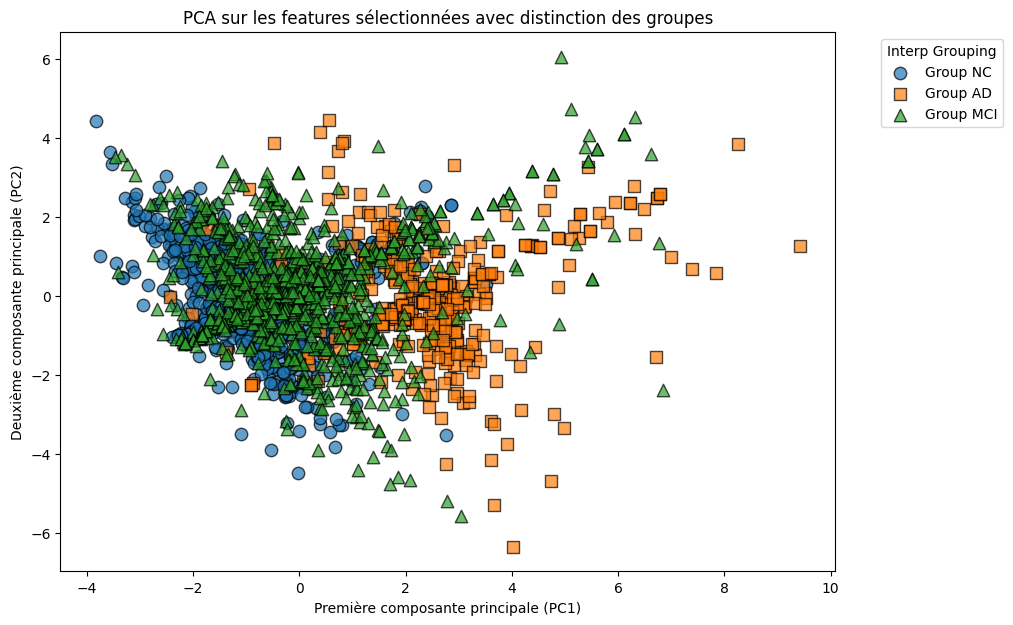

In [22]:

# Créer une palette de couleurs basée sur le nombre de groupes uniques
unique_groups = df_pca["interp_grouping"].nunique()
palette = sns.color_palette("tab10", unique_groups)  # "tab10" donne 10 couleurs distinctes

# Créer une figure
plt.figure(figsize=(10, 7))

# Parcourir chaque groupe et l'afficher avec une couleur unique et un marqueur distinct
markers = ['o', 's', '^', 'D', 'P', '*', 'X', 'H', '+', 'x']  # Différents marqueurs
for i, group in enumerate(df_pca["interp_grouping"].unique()):
    subset = df_pca[df_pca["interp_grouping"] == group]
    plt.scatter(subset["PC1"], subset["PC2"],
                label=f'Group {group}',
                color=palette[i % len(palette)],
                marker=markers[i % len(markers)],
                edgecolors='black',
                alpha=0.7,
                s=80)  # `s` ajuste la taille des points

# Ajouter légende et titres
plt.legend(title="Interp Grouping", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Première composante principale (PC1)")
plt.ylabel("Deuxième composante principale (PC2)")
plt.title("PCA sur les features sélectionnées avec distinction des groupes")

# Afficher le graphique
plt.show()


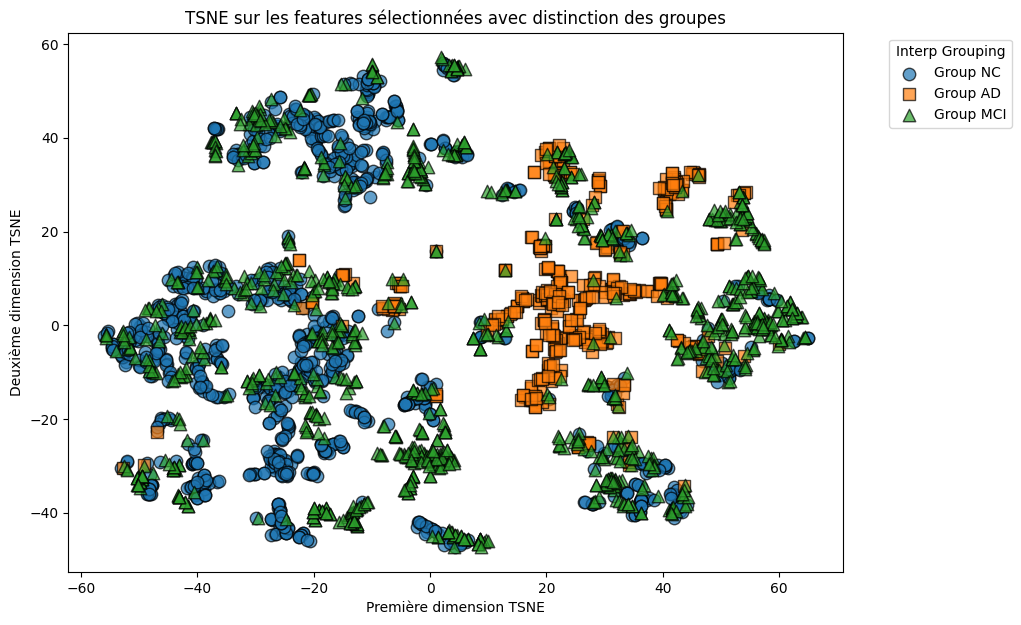

In [23]:

# Appliquer TSNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Création d'un DataFrame avec les nouvelles composantes TSNE
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["interp_grouping"] = y.values  # Ajouter les groupes

# Palette de couleurs basée sur le nombre de groupes
unique_groups = df_tsne["interp_grouping"].nunique()
palette = sns.color_palette("tab10", unique_groups)

# Marqueurs différents pour chaque groupe
markers = ['o', 's', '^', 'D', 'P', '*', 'X', 'H', '+', 'x']

# Création de la figure
plt.figure(figsize=(10, 7))

# Affichage des groupes avec couleurs et marqueurs distincts
for i, group in enumerate(df_tsne["interp_grouping"].unique()):
    subset = df_tsne[df_tsne["interp_grouping"] == group]
    plt.scatter(subset["TSNE1"], subset["TSNE2"],
                label=f'Group {group}',
                color=palette[i % len(palette)],
                marker=markers[i % len(markers)],
                edgecolors='black',
                alpha=0.7,
                s=80)

# Ajouter légende et titres
plt.legend(title="Interp Grouping", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Première dimension TSNE")
plt.ylabel("Deuxième dimension TSNE")
plt.title("TSNE sur les features sélectionnées avec distinction des groupes")

# Afficher le graphique
plt.show()


In [24]:

# Sélection des features pour PCA 2D et t-SNE 2D
X_pca = df_pca[["PC1", "PC2"]]
X_tsne = df_tsne[["TSNE1", "TSNE2"]]
y = df_pca["interp_grouping"]  # Cible (même pour t-SNE et PCA)

# Standardisation des données
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
X_tsne_scaled = scaler.fit_transform(X_tsne)

# Split en train/test avec stratification
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_tsne_train, X_tsne_test, _, _ = train_test_split(X_tsne_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Modèles KNN et Random Forest
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement et Prédiction avec PCA
knn.fit(X_pca_train, y_train)
rf.fit(X_pca_train, y_train)
y_pred_knn_pca = knn.predict(X_pca_test)
y_pred_rf_pca = rf.predict(X_pca_test)

# Entraînement et Prédiction avec t-SNE
knn.fit(X_tsne_train, y_train)
rf.fit(X_tsne_train, y_train)
y_pred_knn_tsne = knn.predict(X_tsne_test)
y_pred_rf_tsne = rf.predict(X_tsne_test)

# Résultats et Évaluation
def evaluation_model(y_true, y_pred, model_name, reduction_type):
    print(f"\n🔹 {model_name} avec {reduction_type} :")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Résultats pour PCA
evaluation_model(y_test, y_pred_knn_pca, "KNN", "PCA")
evaluation_model(y_test, y_pred_rf_pca, "Random Forest", "PCA")

# Résultats pour t-SNE
evaluation_model(y_test, y_pred_knn_tsne, "KNN", "t-SNE")
evaluation_model(y_test, y_pred_rf_tsne, "Random Forest", "t-SNE")



🔹 KNN avec PCA :
Accuracy : 0.7486725663716814
              precision    recall  f1-score   support

          AD       0.77      0.84      0.80        94
         MCI       0.72      0.75      0.74       245
          NC       0.77      0.71      0.74       226

    accuracy                           0.75       565
   macro avg       0.75      0.77      0.76       565
weighted avg       0.75      0.75      0.75       565


🔹 Random Forest avec PCA :
Accuracy : 0.7752212389380531
              precision    recall  f1-score   support

          AD       0.77      0.87      0.82        94
         MCI       0.75      0.78      0.76       245
          NC       0.81      0.73      0.77       226

    accuracy                           0.78       565
   macro avg       0.78      0.79      0.78       565
weighted avg       0.78      0.78      0.77       565


🔹 KNN avec t-SNE :
Accuracy : 0.831858407079646
              precision    recall  f1-score   support

          AD       0.91     

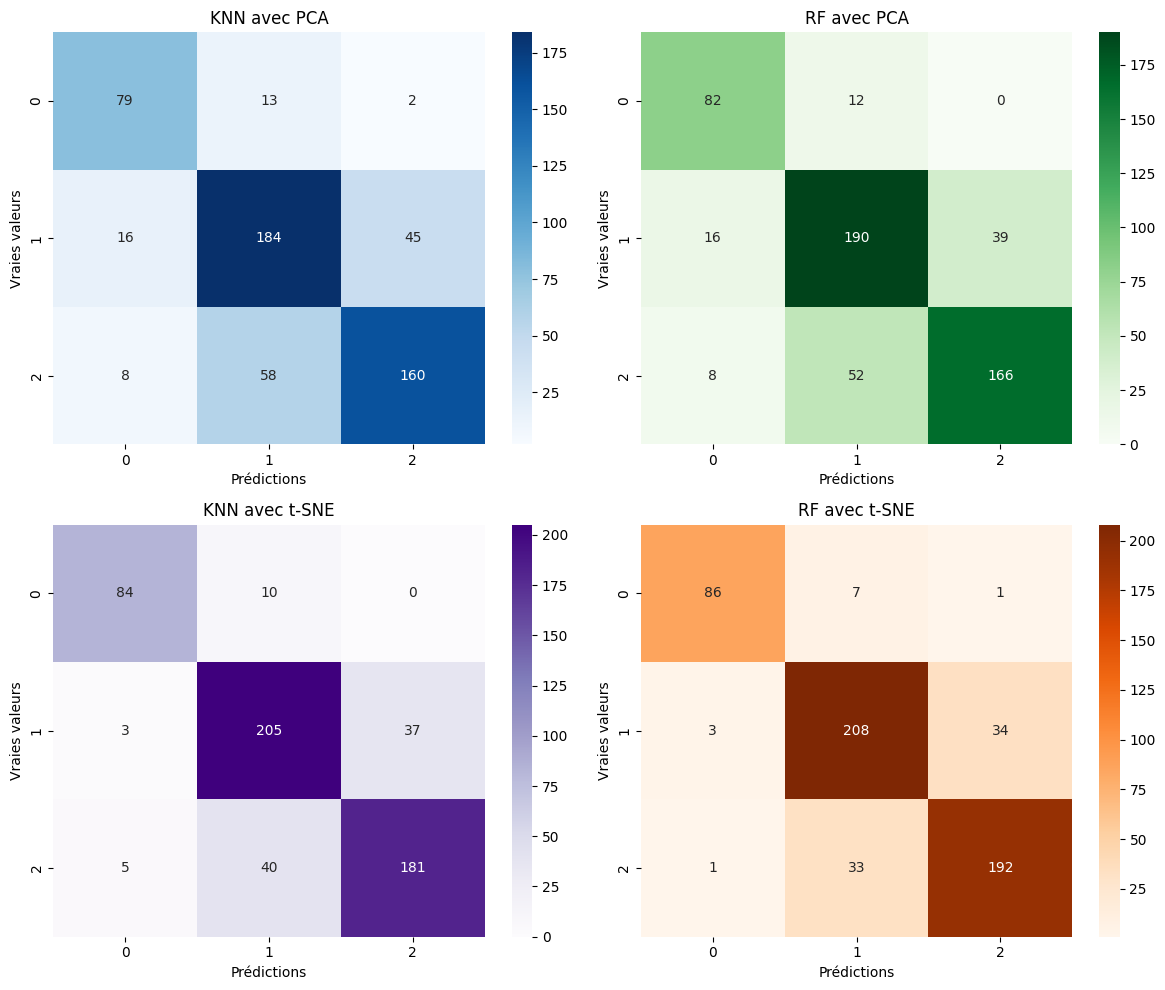

In [25]:
# Affichage des matrices de confusion
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = [
    ("KNN avec PCA", confusion_matrix(y_test, y_pred_knn_pca), axes[0, 0], "Blues"),
    ("RF avec PCA", confusion_matrix(y_test, y_pred_rf_pca), axes[0, 1], "Greens"),
    ("KNN avec t-SNE", confusion_matrix(y_test, y_pred_knn_tsne), axes[1, 0], "Purples"),
    ("RF avec t-SNE", confusion_matrix(y_test, y_pred_rf_tsne), axes[1, 1], "Oranges")
]

for title, matrix, ax, cmap in models:
    sns.heatmap(matrix, annot=True, fmt="d", cmap=cmap, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vraies valeurs")

plt.tight_layout()
plt.show()

## 3. Implémentation d'un réseau de neurones avec softmax et cross-entropy loss- PCA

In [27]:
# Paramètres
EPOCHS = 150
BATCH_SIZE = 16
LEARNING_RATE = 0.01
K_FOLDS = 5  # Nombre de folds pour la cross-validation

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_scaled)

# Encoder les labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convertir en tenseurs PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Définition du modèle
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

In [33]:
# Cross-Validation avec K-Folds
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

train_losses_all, val_losses_all = [], []
train_accuracies_all, val_accuracies_all = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"\n Fold {fold+1}/{K_FOLDS}")

    # Création des sous-ensembles train/validation
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Instancier le modèle
    input_dim = X_train.shape[1]
    output_dim = len(np.unique(y_encoded))
    model = NeuralNet(input_dim, output_dim)

    # Définition de la fonction de perte et de l'optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Listes pour stocker les résultats de ce fold
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []



    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0.0
        correct_train, total_train = 0, 0

        # Entraînement
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Calcul de l'accuracy en entraînement
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Évaluation sur la validation
        model.eval()
        correct_val, total_val = 0, 0
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                # Calcul de l'accuracy en validation
                _, predicted = torch.max(outputs, 1)
                total_val += y_batch.size(0)
                correct_val += (predicted == y_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Train Acc: {train_accuracies[-1]:.4f} - Val Acc: {val_accuracies[-1]:.4f}")

    # Stocker les résultats de ce fold
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)
    train_accuracies_all.append(train_accuracies)
    val_accuracies_all.append(val_accuracies)


 Fold 1/5
Epoch 10/150 - Train Loss: 0.8325 - Val Loss: 0.8446 - Train Acc: 0.7229 - Val Acc: 0.6885
Epoch 20/150 - Train Loss: 0.8202 - Val Loss: 0.8196 - Train Acc: 0.7317 - Val Acc: 0.7274
Epoch 30/150 - Train Loss: 0.8124 - Val Loss: 0.7981 - Train Acc: 0.7366 - Val Acc: 0.7451
Epoch 40/150 - Train Loss: 0.8046 - Val Loss: 0.8005 - Train Acc: 0.7428 - Val Acc: 0.7451
Epoch 50/150 - Train Loss: 0.8060 - Val Loss: 0.7934 - Train Acc: 0.7397 - Val Acc: 0.7522
Epoch 60/150 - Train Loss: 0.8018 - Val Loss: 0.7959 - Train Acc: 0.7472 - Val Acc: 0.7522
Epoch 70/150 - Train Loss: 0.8010 - Val Loss: 0.7944 - Train Acc: 0.7472 - Val Acc: 0.7611
Epoch 80/150 - Train Loss: 0.7968 - Val Loss: 0.7915 - Train Acc: 0.7463 - Val Acc: 0.7540
Epoch 90/150 - Train Loss: 0.8013 - Val Loss: 0.7898 - Train Acc: 0.7446 - Val Acc: 0.7558
Epoch 100/150 - Train Loss: 0.8009 - Val Loss: 0.7984 - Train Acc: 0.7455 - Val Acc: 0.7469
Epoch 110/150 - Train Loss: 0.7949 - Val Loss: 0.7968 - Train Acc: 0.7517 - Va

In [42]:
# Moyenne des résultats sur tous les folds
train_losses = np.mean(train_losses_all, axis=0)
val_losses = np.mean(val_losses_all, axis=0)
train_accuracies = np.mean(train_accuracies_all, axis=0)
val_accuracies = np.mean(val_accuracies_all, axis=0)
print("La validation moyenne obtenue est ",val_accuracies.mean())
print("La précision moyenne obtenue est ",train_accuracies.mean())

La validation moyenne obtenue est  0.7361019351869286
La précision moyenne obtenue est  0.740877730637594


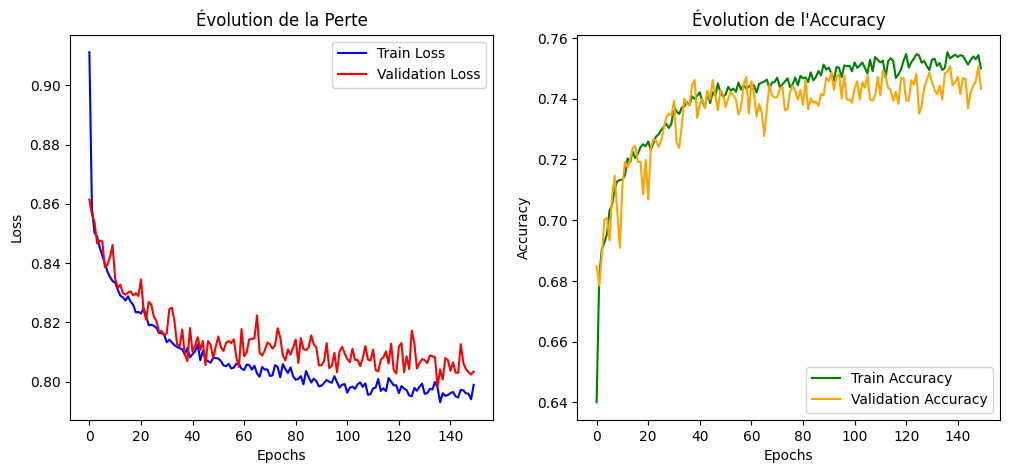

In [41]:
# Affichage des courbes
plt.figure(figsize=(12, 5))

# Courbe des pertes
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Évolution de la Perte")
plt.legend()

# Courbe des accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green")
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Évolution de l'Accuracy")
plt.legend()

plt.show()